# Feature Extraction Networks: 
 1) VGG-19 (Noisy !!)

 2) Random Shallow Nets ( Music Content Overlaps )

 3)Random Shallow Nets  + BFGS(royden-Fletcher-Goldfarb-Shanno)
# Import Libraries

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow
print(tensorflow.__version__)


1.15.2


In [3]:
import tensorflow as tf
import librosa
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
CONTENT_FILENAME ="/content/drive/MyDrive/Nokia/mp3 data/data/imperial.mp3" #"/content/drive/MyDrive/Nokia/mp3 data/data/93.mp3"
STYLE_FILENAME ="/content/drive/MyDrive/Nokia/mp3 data/data/usa.mp3" #"/content/drive/MyDrive/Nokia/mp3 data/data/92.mp3"

In [8]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))




In [9]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectum(filename,outputFileName):
    x, fs = librosa.load(filename)
    librosa.output.write_wav("/content/" + outputFileName, x, fs)

    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

In [10]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME, "Content.mp3")
a_style, fs = read_audio_spectum(STYLE_FILENAME , "Style.mp3")

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, :N_SAMPLES]


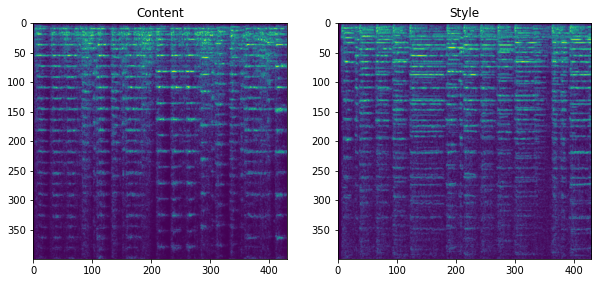

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.show()

In [12]:
N_FILTERS = 4096

a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])

# filter shape is "[filter_height, filter_width, in_channels, out_channels]"
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
kernel = np.random.randn(1, 11, N_CHANNELS, N_FILTERS)*std
    
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    # data shape is "[batch, in_height, in_width, in_channels]",
    x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="xx")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    
    net = tf.nn.relu(conv)

    content_features = net.eval(feed_dict={x: a_content_tf})
    style_features = net.eval(feed_dict={x: a_style_tf})
    
    features = np.reshape(style_features, (-1, N_FILTERS))
    style_gram = np.matmul(features.T, features) / N_SAMPLES


In [13]:
from sys import stderr

ALPHA= 1e-2
learning_rate= 1e-3
iterations = 100

result = None
with tf.Graph().as_default():

    # Build graph with variable input
#     x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")
    x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    
    net = tf.nn.relu(conv)

    content_loss = ALPHA * 2 * tf.nn.l2_loss(
            net - content_features)

    style_loss = 0

    _, height, width, number = map(lambda i: i.value, net.get_shape())

    size = height * width * number
    feats = tf.reshape(net, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

     # Overall loss
    loss = content_loss + style_loss ## Remove style weight for other examples

    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter': 500})
        
    # Optimization
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
       
        print('Started optimization.')
        opt.minimize(sess)
    
        print('Final loss:', loss.eval())
        result = x.eval()



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Started optimization.
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 546.124939
  Number of iterations: 500
  Number of functions evaluations: 524
Final loss: 546.12494


In [14]:
a = np.zeros_like(a_content)
a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
  print("Iteration Number :" + str(i))
  S = a * np.exp(1j*p)
  x = librosa.istft(S)
  p = np.angle(librosa.stft(x, N_FFT))



Iteration Number :0
Iteration Number :1
Iteration Number :2
Iteration Number :3
Iteration Number :4
Iteration Number :5
Iteration Number :6
Iteration Number :7
Iteration Number :8
Iteration Number :9
Iteration Number :10
Iteration Number :11
Iteration Number :12
Iteration Number :13
Iteration Number :14
Iteration Number :15
Iteration Number :16
Iteration Number :17
Iteration Number :18
Iteration Number :19
Iteration Number :20
Iteration Number :21
Iteration Number :22
Iteration Number :23
Iteration Number :24
Iteration Number :25
Iteration Number :26
Iteration Number :27
Iteration Number :28
Iteration Number :29
Iteration Number :30
Iteration Number :31
Iteration Number :32
Iteration Number :33
Iteration Number :34
Iteration Number :35
Iteration Number :36
Iteration Number :37
Iteration Number :38
Iteration Number :39
Iteration Number :40
Iteration Number :41
Iteration Number :42
Iteration Number :43
Iteration Number :44
Iteration Number :45
Iteration Number :46
Iteration Number :47
It

In [15]:
OUTPUT_FILENAME = '/content/output.mp3'
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)
print(OUTPUT_FILENAME)
display(Audio(OUTPUT_FILENAME))

/content/output.mp3


In [16]:
print(OUTPUT_FILENAME)

/content/output.mp3


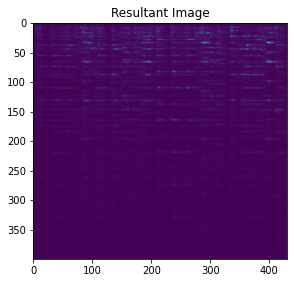

In [38]:
## Resulant spectrogram Image
result = result.reshape((1025,430));
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Resultant Image')
plt.imshow(a[:400,:])
plt.show()

In [36]:
print(a.shape)

(1025, 430)
